The project is based on the "Electrical Grid Stability Simulated Dataset", created by Vadim Arzamasov (Karlsruher Institut für Technologie, Karlsruhe, Germany) and donated to the University of California (UCI) Machine Learning Repository. Reference is taken from Kaggle.

Two primary references support this project and demand special mention:

    "Taming instabilities in power grid networks by decentralized control" (B. Schäfer, et al, The European Physical Journal, Special Topics, 2016, 225.3: 569-582), in which Dr. Schäfer (Network Dynamics, Max Planck Institute for Dynamics and Self-Organization - MPIDS, Göttingen, Germany) and his co-authors describe in detail the DSGC (Decentral Smart Grid Control) differential equation-based model to assess stability of smart grids;
    
    "Towards Concise Models of Grid Stability" (V. Arzamasov, K. Böhm and P. Jochem, 2018 IEEE International Conference on Communications, Control, and Computing Technologies for Smart Grids (SmartGridComm), Aalborg, 2018, pp. 1-6), in which Dr. Arzamasov and his co-authors explore how data-mining techniques can address DSGC model simplifications.


In [7]:
# Initial Setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense

from datetime import datetime


In [8]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()

    
def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=True, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()

In [9]:
# Importing datasets
sns.set()
start_time = datetime.now()

data = pd.read_csv('smart_grid_stability_augmented.csv')

map1 = {'unstable': 0, 'stable': 1}
data['stabf'] = data['stabf'].replace(map1)

data = data.sample(frac=1)

In [10]:
# EDA
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
23111,2.779802,8.702879,5.268349,8.919421,3.708977,-1.339941,-1.838301,-0.530735,0.957784,0.340386,0.220510,0.616216,0.015124,0
28660,0.864977,7.034694,6.564474,2.512981,3.269693,-0.743146,-1.603396,-0.923150,0.816809,0.755758,0.579344,0.323980,0.001227,0
19566,7.884118,3.136414,2.085928,2.958196,3.289595,-0.583110,-1.450110,-1.256374,0.051708,0.361610,0.955224,0.483532,-0.023780,1
39074,7.037249,3.787841,9.873874,9.070729,2.927064,-1.055642,-0.924928,-0.946494,0.555038,0.811699,0.411642,0.401510,0.041282,0
17325,3.898923,9.716076,6.908035,2.668062,2.322758,-1.147340,-0.536508,-0.638910,0.411028,0.484173,0.324234,0.524948,-0.002836,1


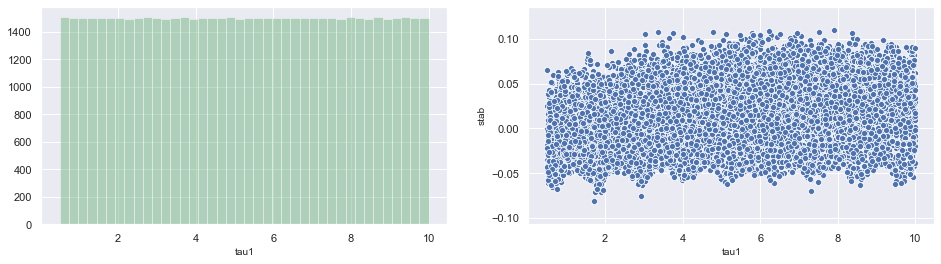

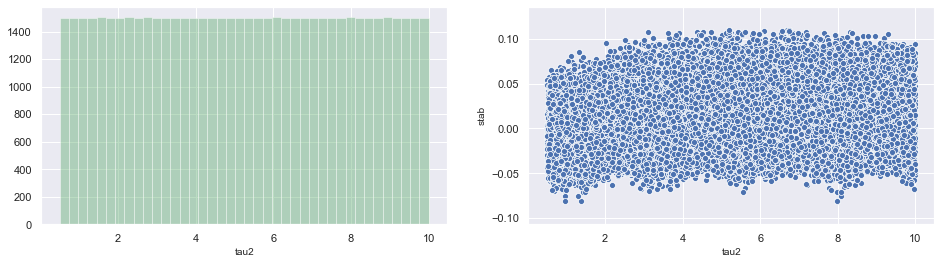

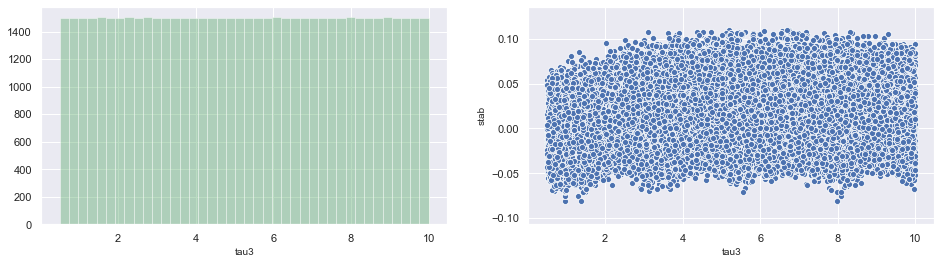

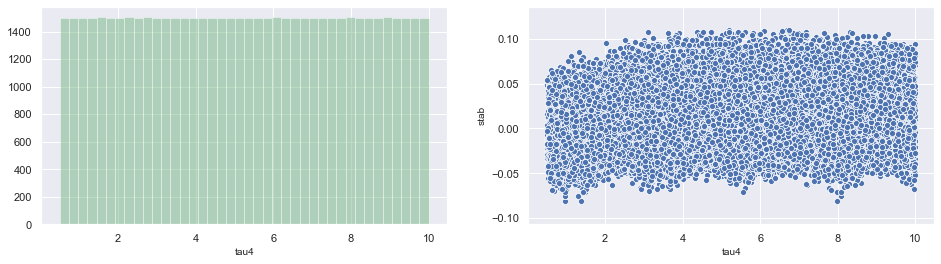

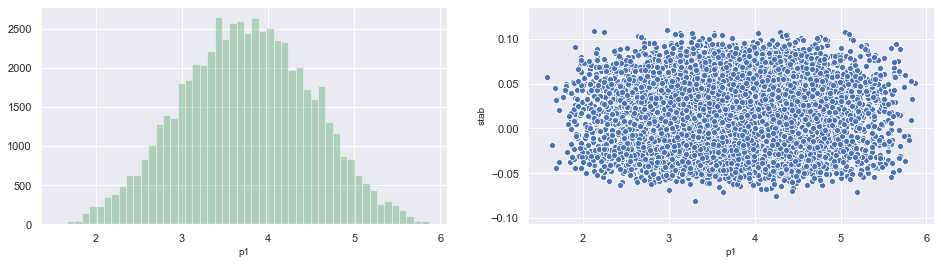

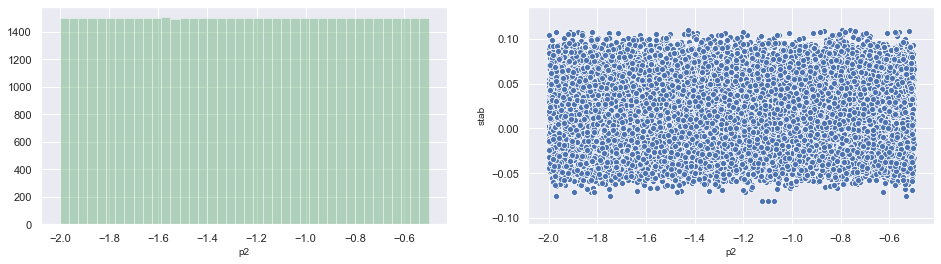

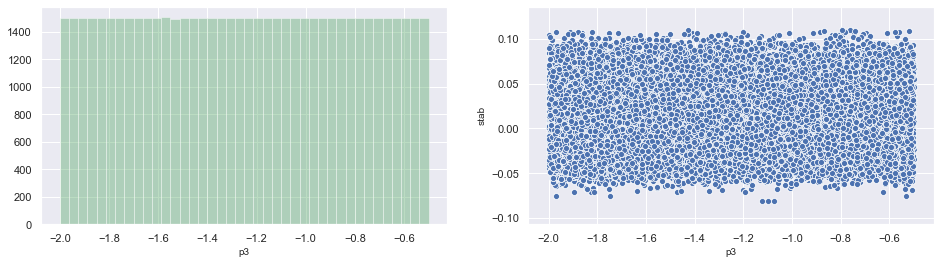

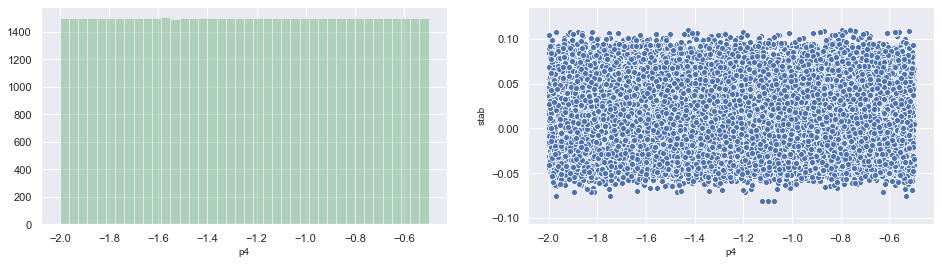

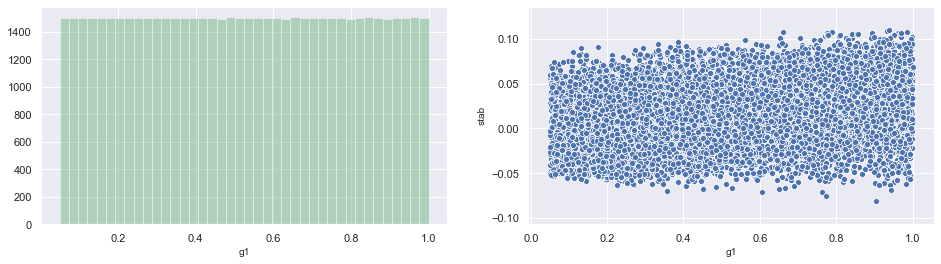

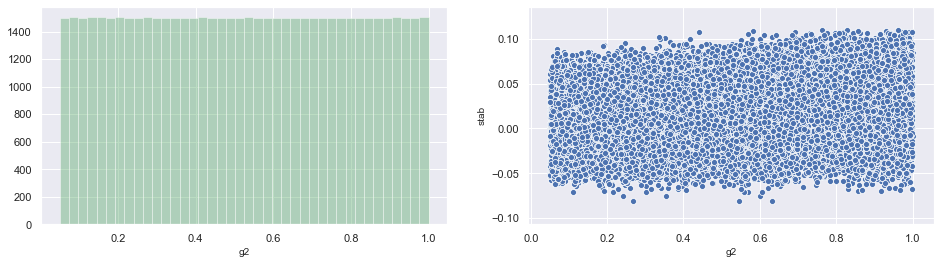

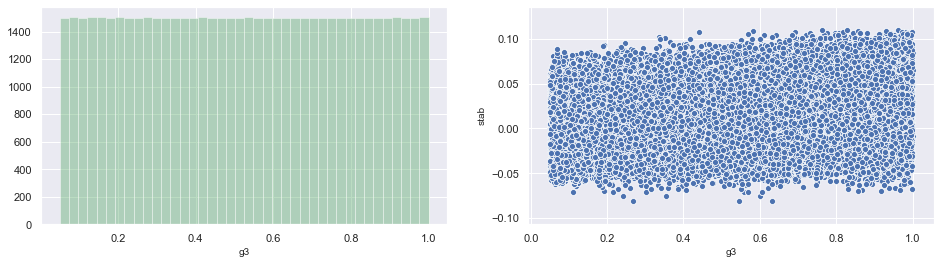

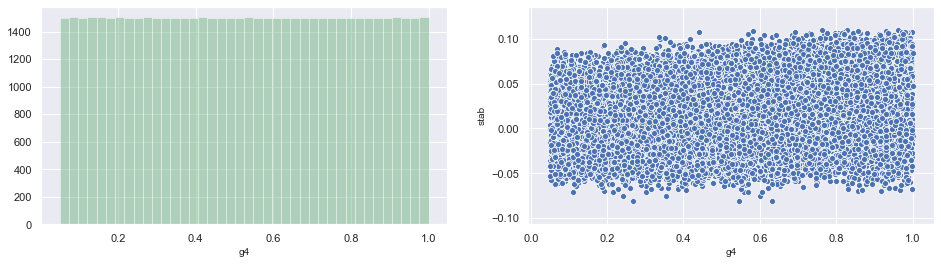

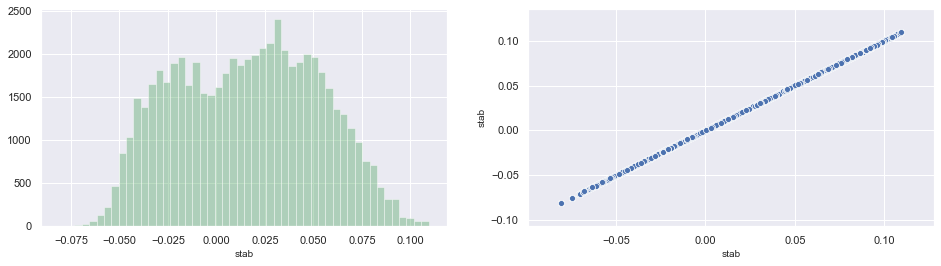

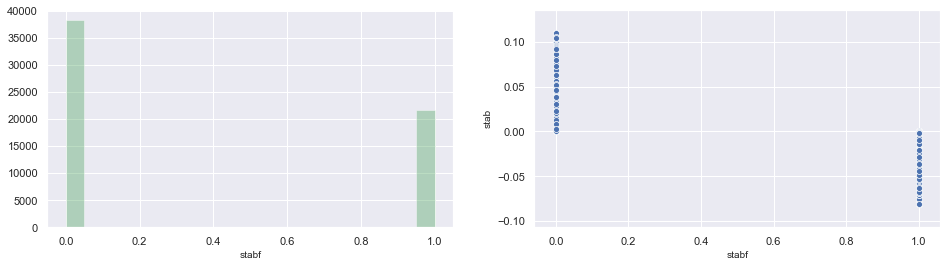

In [11]:
# Features assessment
for column in data.columns:
    assessment(data, 'stab', column, -1)

In [12]:
data.p1.skew()

-0.012688423269883484

In [14]:
print(f'Split of "unstable" (0) and "stable" (1) observations in the original dataset:')
print(data['stabf'].value_counts(normalize=True))

Split of "unstable" (0) and "stable" (1) observations in the original dataset:
0    0.638
1    0.362
Name: stabf, dtype: float64


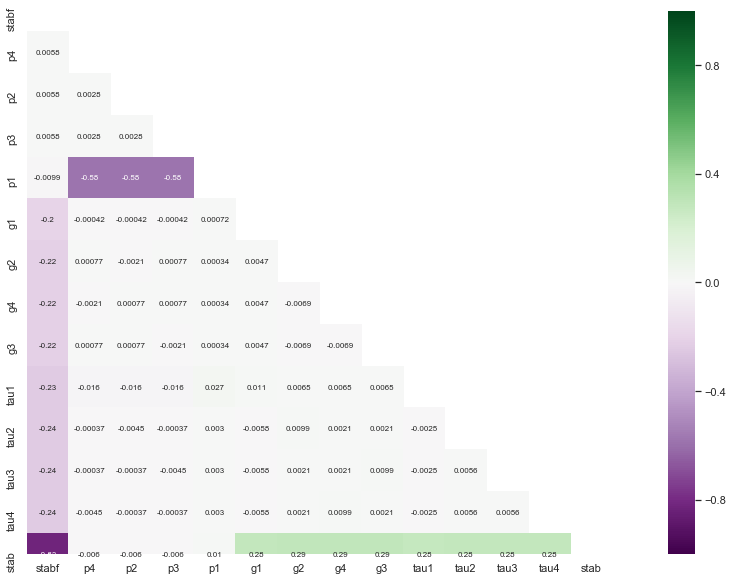

In [15]:
correlation_map(data, 'stabf', 14)

In [16]:
# Segregating train and data sets
X = data.iloc[:, :12]
y = data.iloc[:, 13]

X_training = X.iloc[:54000, :]
y_training = y.iloc[:54000]

X_testing = X.iloc[54000:, :]
y_testing = y.iloc[54000:]

ratio_training = y_training.value_counts(normalize=True)
ratio_testing = y_testing.value_counts(normalize=True)
ratio_training, ratio_testing

(0    0.63813
 1    0.36187
 Name: stabf, dtype: float64, 0    0.636833
 1    0.363167
 Name: stabf, dtype: float64)

In [17]:
X_training = X_training.values
y_training = y_training.values

X_testing = X_testing.values
y_testing = y_testing.values

In [18]:
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

In [19]:
'''The artificial neural network (ANN) architecture depicted below is the optimal one evaluated in this study. 
It reflects an sequential structure with:
    - one input layer (12 input nodes);
    - three hidden layers (24, 24 and 12 nodes, respectively);
    - one single-node output layer.
'''

# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Third hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
# Model fitting
cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier.fit(x_train, y_train, epochs=50, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1

Model evaluation

169/169 [==============================] - 0s 990us/step - loss: 0.0793 - accuracy: 0.9635
Round 1 - Loss: 0.0793 | Accuracy: 96.35 %
169/169 [==============================] - 0s 859us/step - loss: 0.0640 - accuracy: 0.9752
Round 2 - Loss: 0.0640 | Accuracy: 97.52 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0624 - accuracy: 0.9737
Round 3 - Loss: 0.0624 | Accuracy: 97.37 %
169/169 [==============================] - 0s 985us/step - loss: 0.0622 - accuracy: 0.9767
Round 4 - Loss: 0.0622 | Accuracy: 97.67 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0574 - accuracy: 0.9787
Round 5 - Loss: 0.0574 | Accuracy: 97.87 %
169/169 [==============================] - 0s 890us/step - loss: 0.0558 - accuracy: 0.9770
Round 6 - Loss: 0.0558 | Accuracy: 97.70 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0450 - accuracy: 0.9822
Round 7 - Loss: 0.0450 | Accuracy: 98.22 %
169/169 [==============================] - 0s 862u

In [21]:
y_pred = classifier.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [22]:
# Results
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 97.98%
